In [3]:
import os
import pandas as pd
import numpy as np

import plotly.express as px
import plotly.graph_objs as go

from IPython.display import display

# QUESTION: 
# Is Talon (tutor Costin’s favorite champion) more likely to win or lose any given match?

In [4]:
# Load Dataset
league_fp = os.path.join('data', '2022_LoL_esports_match_data_from_OraclesElixir.csv')
league_raw = pd.read_csv(league_fp)

league_raw.dtypes

/Users/elim-mbp-01/.pyenv/versions/3.8.16/envs/dsc80_39/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3505: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


gameid               object
datacompleteness     object
url                  object
league               object
year                  int64
                     ...   
assistsat15         float64
deathsat15          float64
opp_killsat15       float64
opp_assistsat15     float64
opp_deathsat15      float64
Length: 123, dtype: object

## Data Cleaning

Clean the data appropriately. For instance, you may need to replace data that should be missing with NaN or create new columns out of given ones (e.g. compute distances, scale data, or get time information from time stamps).	

In [5]:
# =======================
# CLEANING 
# =======================

league = league_raw.copy()

# =======================================================
# Some rows are marked with datacompleteness = "partial"/"ignore".
# According to Costin, this label just means that there's a NaN value in the row (excluding NaN's from team/player related columns)
# league = league[league["datacompleteness"] == "complete"]
# =======================================================

# =======================================================
# Each 'gameid' corresponds to up to 12 rows – one for each of the 5 players on both teams and 2 containing summary data for the two teams (try to find out what distinguishes those rows). After selecting your line of inquiry, make sure to remove either the player rows or the team rows so as not to have issues later in your analysis.

# 24900 rows without a champion 
# (league_raw["champion"].isna()).sum()
# 149400 rows total. 12 rows per match. 149400 / 12 = 12450 matches. 
# 12450 * 2 = 24900 team related rows
# (149400 / 12) = 12450 matches. 12450 * 2 = 24900
# Filtering by whether there's a champion listed or not, should get only the player related rows
league = league[league["champion"].notna()]

# Also drop the team related columns. Every single value in those columns should be null for the player related rows
team_columns_mask = league.isnull().sum(axis=0) == league.shape[0]
league = league.drop(columns=league.columns[team_columns_mask])
print(f"{team_columns_mask.sum()} team-related columns removed")
# =======================================================

# =======================================================
# NaN values for players are represented as "unkown player"
# Mark these as NaN
league["playername"] = league["playername"].apply(lambda val: np.nan if val == "unknown player" else val)
# =======================================================


# =======================================================
# Many columns should be of type bool but are not.
# Checks each column to see if the set of unique values is {0, 1}
# If so, converts the column to bool
columns_to_bool = []
for column in league.columns:
    value_counts = league[column].value_counts()
    if set(value_counts.index) == {0, 1}:
        columns_to_bool.append(column)
        league[column] = league[column].astype(bool)
print(f"CONVERTED {len(columns_to_bool)} COLUMNS TO BOOL")
# =======================================================

# =======================================================
league = league.convert_dtypes()
league.info()
# =======================================================

26 team-related columns removed
CONVERTED 6 COLUMNS TO BOOL
<class 'pandas.core.frame.DataFrame'>
Int64Index: 124500 entries, 0 to 149397
Data columns (total 97 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   gameid                    124500 non-null  string 
 1   datacompleteness          124500 non-null  string 
 2   url                       18680 non-null   string 
 3   league                    124500 non-null  string 
 4   year                      124500 non-null  Int64  
 5   split                     90070 non-null   string 
 6   playoffs                  124500 non-null  boolean
 7   date                      124500 non-null  string 
 8   game                      124500 non-null  Int64  
 9   patch                     124410 non-null  Float64
 10  participantid             124500 non-null  Int64  
 11  side                      124500 non-null  string 
 12  position                  124500 non-nul

In [6]:
league.head()

gameid datacompleteness   url  league  year   split  \
0  ESPORTSTMNT01_2690210         complete  <NA>  LCK CL  2022  Spring   
1  ESPORTSTMNT01_2690210         complete  <NA>  LCK CL  2022  Spring   
2  ESPORTSTMNT01_2690210         complete  <NA>  LCK CL  2022  Spring   
3  ESPORTSTMNT01_2690210         complete  <NA>  LCK CL  2022  Spring   
4  ESPORTSTMNT01_2690210         complete  <NA>  LCK CL  2022  Spring   

   playoffs                 date  game  patch  ...  opp_csat15 golddiffat15  \
0     False  2022-01-10 07:44:08     1  12.01  ...         121          391   
1     False  2022-01-10 07:44:08     1  12.01  ...         100          541   
2     False  2022-01-10 07:44:08     1  12.01  ...         119         -475   
3     False  2022-01-10 07:44:08     1  12.01  ...         149         -793   
4     False  2022-01-10 07:44:08     1  12.01  ...          21          443   

  xpdiffat15 csdiffat15 killsat15 assistsat15 deathsat15 opp_killsat15  \
0        345         14         0           1          0             0   
1       -275        -11         2           3          2             0   
2        153          1         0           3          0             3   
3      -1343        -34         2           1          2             3   
4       -497          7         1           2          2             0   

  opp_assistsat15 opp_deathsat15  
0               1              0  
1               5              1  
2               3              2  
3               3              0  
4               6              2  

[5 rows x 97 columns]

## UNIVARIATE ANALYSIS

Look at the distributions of relevant columns separately by using DataFrame operations and drawing at least two relevant plots.	

In [7]:
# =======================
# Amount of times each champion is used
# - Talon bar indicated in red on the right of the largest bar for reference
#       - Only used 50 Times
# - Shows that this hero is not very popular in the competitive scene
# =======================

champion_freq = league.champion.value_counts().to_frame()
champion_freq["is_talon"] = champion_freq.index == "Talon"
champion_freq.sort_values(by="champion", inplace=True)

px.bar(
    x=champion_freq.index, 
    y=champion_freq["champion"], 
    color=champion_freq["is_talon"],
    title='Total Number of Times Each Champion is Used In Competitive Matches (2022)',
    labels={'x':'Champion Name', 'y': 'Number of Times Used', 'color': 'Is Talon'},
)
# ).write_html("champion_freq.html", include_plotlyjs="cdn")

# NOTE: 
# Due to size constraints, the following bar plot only periodically lists champion names on the x-axis. 
# Hover over a bar to see the champion name. 
# One can also zoom into a section to see champion names within that section on the x-axis


In [8]:
# =======================
# Density Histogram of # of Kills
# - Another histogram of Talon kills are provided for 
# =======================

histogram_trace_1 = go.Histogram(
    name="All Champions",
    x=league["kills"], 
    opacity=0.5, 
    histnorm='probability'
)

histogram_trace_2 = go.Histogram(
    name="Talon",
    x=league[league["champion"] == "Talon"]["kills"], 
    opacity=0.5, histnorm='probability'
)

fig = go.Figure(data=[histogram_trace_1, histogram_trace_2])
fig.update_layout(barmode='overlay', title_text='Density Histogram of # of Kills', xaxis_title_text='Number of Kills', yaxis_title_text='Relative Frequency', )
# fig.write_html("kills_histogram.html", include_plotlyjs="cdn")
fig.show()

## Bivariate Analysis

Look at the statistics of pairs of columns to identify possible associations. For instance, you may create scatter plots and plot conditional distributions, or box-plots. You must plot at least two such plots in your notebook. The results of your bivariate analyses will be helpful in identifying interesting hypothesis tests!	

In [9]:
# Wins and loses per champion: (Use columns: 'champion' and 'result')
wins = league[league.result]['champion'].value_counts().to_frame()
losses = league[league.result == False]['champion'].value_counts().to_frame()
wins_and_losses = wins.merge(losses, left_index=True, right_index=True, how='left').fillna(0)
wins_and_losses.columns = ['Wins', 'Losses']

# Wins = Blue
fig = px.bar(
    wins_and_losses, 
    x=wins_and_losses.index, 
    y=wins_and_losses.Wins, 
    title='Frequency of Champions where a match was won and lost',
    labels={'index':'Champions', 'Wins':'counts'},
)
# Losses = Red
fig = fig.add_bar(
    x=wins_and_losses.index, 
    y=wins_and_losses.Losses, 
    base='relative',
    opacity=0.5,
    name='Losses'
)
# fig.write_html("wins_and_losses.html", include_plotlyjs="cdn")
fig.show()

In [10]:
# Relationship between kills and deaths:
px.scatter(league, x=league.kills, y=league.deaths)
#.write_html("kills_vs_deaths.html", include_plotlyjs="cdn")

## Interesting Aggregates

Choose columns to group and pivot by and examine aggregate statistics.	

In [11]:
talon_rows = league[league["champion"] == "Talon"]
talon_rows["position"].value_counts()

jng    52
mid    13
Name: position, dtype: Int64

In [12]:
league.columns.to_list()

# league.position.value_counts()

# when u win, ur gpm higher
pd.pivot_table(
    league,
    index=['result'],
    columns=['position'],
    values=['earned gpm'],
    aggfunc='mean'
)

earned gpm                                                
position         bot         jng         mid         sup         top
result                                                              
False     257.325609  178.836277  231.934278   87.353803  223.427108
True      342.339424  245.857746  302.894982  133.629274  292.376865

In [13]:

# blue side seems to be favored in kills
league["kills"] = league["kills"].astype(float)
pd.pivot_table(
    league,
    index=["side"],
    columns=["position"],
    values=["kills"],
    aggfunc="mean"
)

kills                                        
position       bot       jng       mid       sup       top
side                                                      
Blue      4.346667  3.138313  3.555663  0.894378  2.833092
Red       4.170924  2.975582  3.447229  0.852450  2.756386

## NMAR Analysis

Recall, to determine whether data are likely NMAR, you must reason about the data generating process; you cannot conclude that data are likely NMAR solely by looking at your data. As such, there’s no code to write here (and hence, nothing to put in your notebook).	

In [14]:
# The playernames column could be NMAR (Not Missing At Random). If the player name is missing, it could be the case that the player name is offensive and therefore would be removed from being displayed. Considering that the game is League of Legends, which often has a perception of it's playerbase not being the nicest of individuals, this could be a possibility. Although these are competitive matches, qualifiers are often "open" where any individual can sign up and play. With there being no link to a real identity and there sheer amount of players, it's perhaps inevitable that some disatisfactory names slips through. 

In [177]:
# =====================
# HYPOTHESIS TEST
# =====================

# Null Hypothesis: Talon's win rate is 50%
# Alternative Hypothesis: Talon's win rate is greater than 50%

# Test Shatistic: Talon's proportion of matches won. This is an appropiate choice of test statistic, as larger values point towards the alternative hypothesis, and smaller values point towards the null hypothesis.
# Significance Level: 0.05


talon_rows = league[league["champion"] == "Talon"]
observed_ts = talon_rows["result"].mean()
sample_size = talon_rows.shape[0]

sims = np.random.multinomial(sample_size, [0.5, 0.5], size=10000)
tss = sims[:, 0] / float(sample_size)

fig = px.histogram(tss, nbins=22, title="Emperical Distribution of Talon's Win Rate Assuming the Null Hypothesis", labels={"0": "Test Statistic (win proportion)"}, histnorm='probability', x=0)
fig.add_vline(x=observed_ts, line_color='red')
fig.update_layout(xaxis_range=[0, 1])

fig.write_html("talon_win_rate.html", include_plotlyjs="cdn")

# P-Value: 0.2409
# We fail to reject the null hypothesis @ the 0.05 significance level. It should be noted that Talon's true winrate could be greater than 50% (Costin's favorite hero, Talon, is more likely to win than lose any given match), however, we lack sufficient evidence to definitively support this claim.

In [99]:
# =====================
# HYPOTHESIS TEST
# =====================

# Null Hypothesis: Talon's win rate is 50%
# Alternative Hypothesis: Talon's win rate is greater than 50%

# Test Shatistic: Talon's proportion of matches won. This is an appropiate choice of test statistic, as larger values point towards the alternative hypothesis, and smaller values point towards the null hypothesis.
# Significance Level: 0.05

talon_rows = league[league["champion"] == "Talon"]
observed_ts = talon_rows["result"].mean()

print(talon_rows.shape, observed_ts)

sims = np.random.multinomial(
    talon_rows.shape[0], 
    [0.5, 0.5], 
    size=10000
)

# sims:       10000 x 2 matrix
# sims.sum:   10000 x 1 matrix
tss = (sims / talon_rows.shape[0])
tss = tss[:, 0]

p = (tss >= observed_ts).mean()
print(observed_ts, p)

fig = px.histogram(tss, histnorm='probability', title='Samples Simulated Under the Null')
fig
# fig.add_vline(x=observed_ts, line_color='red')

# P-Value: 0.2409
# We fail to reject the null hypothesis @ the 0.05 significance level. It should be noted that Talon's true winrate could be greater than 50% (Costin's favorite hero, Talon, is more likely to win than lose any given match), however, we lack sufficient evidence to definitively support this claim.


(65, 97) 0.5538461538461539
0.5538461538461539 0.2322


In [16]:
league.loc[
    (league["champion"] == "Talon"),
    :
].shape

(65, 97)

In [17]:
league_raw["datacompleteness"].value_counts()

complete    127044
partial      21828
ignore         528
Name: datacompleteness, dtype: int64

In [18]:
league.columns.to_list()

['gameid',
 'datacompleteness',
 'url',
 'league',
 'year',
 'split',
 'playoffs',
 'date',
 'game',
 'patch',
 'participantid',
 'side',
 'position',
 'playername',
 'playerid',
 'teamname',
 'teamid',
 'champion',
 'ban1',
 'ban2',
 'ban3',
 'ban4',
 'ban5',
 'gamelength',
 'result',
 'kills',
 'deaths',
 'assists',
 'teamkills',
 'teamdeaths',
 'doublekills',
 'triplekills',
 'quadrakills',
 'pentakills',
 'firstblood',
 'firstbloodkill',
 'firstbloodassist',
 'firstbloodvictim',
 'team kpm',
 'ckpm',
 'barons',
 'opp_barons',
 'inhibitors',
 'opp_inhibitors',
 'damagetochampions',
 'dpm',
 'damageshare',
 'damagetakenperminute',
 'damagemitigatedperminute',
 'wardsplaced',
 'wpm',
 'wardskilled',
 'wcpm',
 'controlwardsbought',
 'visionscore',
 'vspm',
 'totalgold',
 'earnedgold',
 'earned gpm',
 'earnedgoldshare',
 'goldspent',
 'total cs',
 'minionkills',
 'monsterkills',
 'monsterkillsownjungle',
 'monsterkillsenemyjungle',
 'cspm',
 'goldat10',
 'xpat10',
 'csat10',
 'opp_golda

# Is Talon (tutor Costin’s favorite champion) more likely to win or lose any given match?


In [19]:
matchgb = league_raw.groupby("gameid").get_group("ESPORTSTMNT01_2690210")
matchgb_columns = matchgb.columns.to_list()
matchgb_columns


['gameid',
 'datacompleteness',
 'url',
 'league',
 'year',
 'split',
 'playoffs',
 'date',
 'game',
 'patch',
 'participantid',
 'side',
 'position',
 'playername',
 'playerid',
 'teamname',
 'teamid',
 'champion',
 'ban1',
 'ban2',
 'ban3',
 'ban4',
 'ban5',
 'gamelength',
 'result',
 'kills',
 'deaths',
 'assists',
 'teamkills',
 'teamdeaths',
 'doublekills',
 'triplekills',
 'quadrakills',
 'pentakills',
 'firstblood',
 'firstbloodkill',
 'firstbloodassist',
 'firstbloodvictim',
 'team kpm',
 'ckpm',
 'firstdragon',
 'dragons',
 'opp_dragons',
 'elementaldrakes',
 'opp_elementaldrakes',
 'infernals',
 'mountains',
 'clouds',
 'oceans',
 'chemtechs',
 'hextechs',
 'dragons (type unknown)',
 'elders',
 'opp_elders',
 'firstherald',
 'heralds',
 'opp_heralds',
 'firstbaron',
 'barons',
 'opp_barons',
 'firsttower',
 'towers',
 'opp_towers',
 'firstmidtower',
 'firsttothreetowers',
 'turretplates',
 'opp_turretplates',
 'inhibitors',
 'opp_inhibitors',
 'damagetochampions',
 'dpm',
 'd

In [20]:
league_raw.columns.to_list()

['gameid',
 'datacompleteness',
 'url',
 'league',
 'year',
 'split',
 'playoffs',
 'date',
 'game',
 'patch',
 'participantid',
 'side',
 'position',
 'playername',
 'playerid',
 'teamname',
 'teamid',
 'champion',
 'ban1',
 'ban2',
 'ban3',
 'ban4',
 'ban5',
 'gamelength',
 'result',
 'kills',
 'deaths',
 'assists',
 'teamkills',
 'teamdeaths',
 'doublekills',
 'triplekills',
 'quadrakills',
 'pentakills',
 'firstblood',
 'firstbloodkill',
 'firstbloodassist',
 'firstbloodvictim',
 'team kpm',
 'ckpm',
 'firstdragon',
 'dragons',
 'opp_dragons',
 'elementaldrakes',
 'opp_elementaldrakes',
 'infernals',
 'mountains',
 'clouds',
 'oceans',
 'chemtechs',
 'hextechs',
 'dragons (type unknown)',
 'elders',
 'opp_elders',
 'firstherald',
 'heralds',
 'opp_heralds',
 'firstbaron',
 'barons',
 'opp_barons',
 'firsttower',
 'towers',
 'opp_towers',
 'firstmidtower',
 'firsttothreetowers',
 'turretplates',
 'opp_turretplates',
 'inhibitors',
 'opp_inhibitors',
 'damagetochampions',
 'dpm',
 'd

In [21]:
missing_values = league_raw.isna().sum(axis=0)
missing_values[missing_values > 0].to_frame().to_html()

'<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>0</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>url</th>\n      <td>126984</td>\n    </tr>\n    <tr>\n      <th>split</th>\n      <td>41316</td>\n    </tr>\n    <tr>\n      <th>patch</th>\n      <td>108</td>\n    </tr>\n    <tr>\n      <th>playername</th>\n      <td>24900</td>\n    </tr>\n    <tr>\n      <th>playerid</th>\n      <td>27069</td>\n    </tr>\n    <tr>\n      <th>teamname</th>\n      <td>54</td>\n    </tr>\n    <tr>\n      <th>teamid</th>\n      <td>2124</td>\n    </tr>\n    <tr>\n      <th>champion</th>\n      <td>24900</td>\n    </tr>\n    <tr>\n      <th>ban1</th>\n      <td>2334</td>\n    </tr>\n    <tr>\n      <th>ban2</th>\n      <td>2202</td>\n    </tr>\n    <tr>\n      <th>ban3</th>\n      <td>2520</td>\n    </tr>\n    <tr>\n      <th>ban4</th>\n      <td>2388</td>\n    </tr>\n    <tr>\n      <th>ban5</th>\n      <td>2712</td>\n    </tr>\n 

In [22]:
league_test = league_raw.copy()
league_test["ban1_missing"] = league_test["ban1"].isna()

In [23]:
# plot_df = league_test.loc[:, ["ban1_missing", "ban2"]]
# px.histogram(league_test, color='ban1_missing', histnorm='probability', marginal='box', 
#              title="Birth Weight by Mother's Smoking Status", barmode='overlay', opacity=0.7)

In [24]:
def tvd(df: pd.DataFrame, col_tf, col_i: str):
    df_gb = df.groupby(col_tf)[col_i].value_counts()
    dist1 = df_gb[True] / df_gb[True].sum()
    dist2 = df_gb[False] / df_gb[False].sum()
    return 0.5 * np.sum(np.abs(dist1 - dist2))

def diff_of_means(df: pd.DataFrame, col_tf, col_i: str):
    df_gb = df.groupby(col_tf)[col_i].mean()

tvd(league_test, "ban1_missing", "ban2")

0.35992082925236696

In [25]:
def permutation_test(df: pd.DataFrame, col_to_tf: str, col_i: str):
    df_cp = df.copy()
    
    df_cp["is_missing"] = df_cp[col_to_tf].isna()
    observed_test_stat = tvd(df_cp, "is_missing", col_i)
    
    dist = pd.pivot_table(
        df_cp,
        index=col_i,
        columns="is_missing",
        aggfunc="size"
    )
    dist = dist / dist.sum()
    display(dist.plot(title=f"{col_i} by missingness of {col_to_tf}"))
    
    test_stats = []
    for _ in range(100):
        df_cp["is_missing"] = np.random.permutation(df_cp["is_missing"])
        test_stats.append(tvd(df_cp, "is_missing", col_i))
        
    return observed_test_stat, np.array(test_stats)


<AxesSubplot:title={'center':'ban2 by missingness of ban1'}, xlabel='ban2'>

P-Value: 0.0


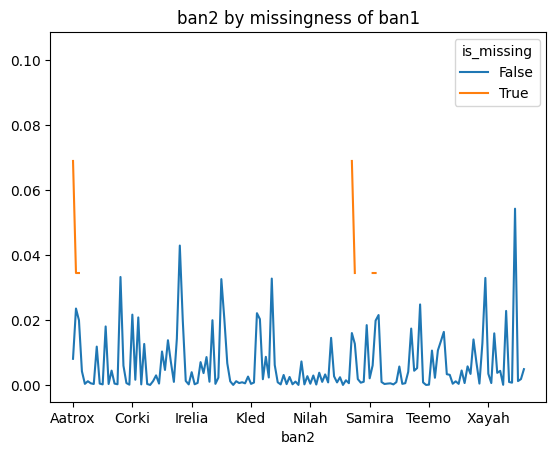

In [26]:
observed_test_stat, test_stats = permutation_test(league_raw, "ban1", "ban2")
print(f"P-Value: {np.mean(test_stats >= observed_test_stat)}")
fig = px.histogram(test_stats, nbins=50, histnorm='probability', title='Emperical Distribution of the TVD - Ban2 by Missingness of Ban1', labels={'value': 'Test Statistic (TVD)'})
fig.add_vline(x=observed_test_stat, line_color='red')
fig.write_html("ban2_by_missingness_of_ban1.html", include_plotlyjs="cdn")
# fig.to_html("ban2_by_missingness_of_ban1.html")

# MAR: ban2

<AxesSubplot:title={'center':'result by missingness of ban1'}, xlabel='result'>

P-Value: 0.93


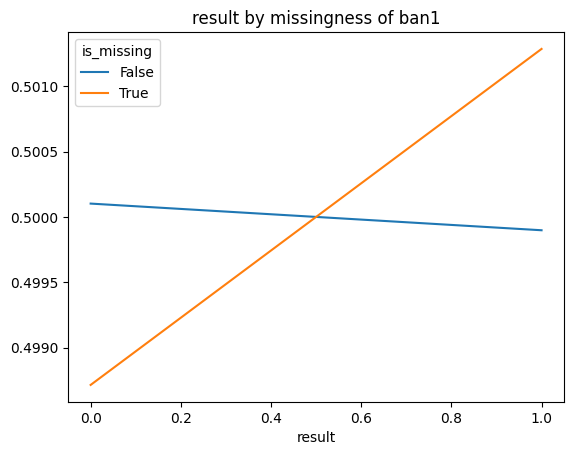

In [28]:
observed_test_stat, test_stats = permutation_test(league_raw, "ban1", "result")
print(f"P-Value: {np.mean(test_stats >= observed_test_stat)}")
fig = px.histogram(test_stats, nbins=50, histnorm='probability', title='Emperical Distribution of the TVD', labels={'value': 'Test Statistic (TVD)'})
fig.add_vline(x=observed_test_stat, line_color='red')
fig.write_html("result_by_missingness_of_ban1.html", include_plotlyjs="cdn")

In [ ]:
league_test.loc[
    league_test["ban1_missing"] == True,
    "ban2"
].value_counts()

Draven          18
Aatrox          12
Renata Glasc    12
Azir            12
Senna            6
Ahri             6
Aphelios         6
Riven            6
Sejuani          6
Amumu            6
Akali            6
Vayne            6
Taliyah          6
Ornn             6
Caitlyn          6
Teemo            6
Renekton         6
Volibear         6
Ezreal           6
Lillia           6
Poppy            6
Syndra           6
Hecarim          6
Yone             6
Name: ban2, dtype: int64

In [ ]:
league_test.groupby("ban1_missing")["ban2"].mean()

TypeError: can only concatenate str (not "int") to str

In [ ]:

faker_data = league_raw.loc[
    # (league_raw["champion"] == "Talon"),
    (league_raw["playername"] == "Faker"),
    ["teamname", "playername", "champion", "result"]
]
faker_data["result"].mean()
# Confirmed that 1 means win, 0 means loss
# https://gol.gg/players/player-stats/48/season-S12/split-ALL/tournament-ALL/J (74.3% WR)

0.7430555555555556

In [ ]:
talon_data = league_raw.loc[
    (league_raw["champion"] == "Talon"),
    ["teamname", "playername", "champion", "result"]
]
talon_data.shape, talon_data["result"].mean()

((65, 4), 0.5538461538461539)

In [ ]:
# EGR - early game rating
# MLR - mid late game rating

In [ ]:
matchgb[["participantid", "teamname", "playername", "champion", "ban1", "ban2", "doublekills", "result"]]

participantid                       teamname playername  champion  \
0               1       Fredit BRION Challengers     Soboro  Renekton   
1               2       Fredit BRION Challengers     Raptor  Xin Zhao   
2               3       Fredit BRION Challengers     Feisty   LeBlanc   
3               4       Fredit BRION Challengers      Gamin    Samira   
4               5       Fredit BRION Challengers      Loopy     Leona   
5               6  Nongshim RedForce Challengers       DnDn    Gragas   
6               7  Nongshim RedForce Challengers     Sylvie     Viego   
7               8  Nongshim RedForce Challengers     FIESTA    Viktor   
8               9  Nongshim RedForce Challengers      vital      Jinx   
9              10  Nongshim RedForce Challengers   Blessing   Alistar   
10            100       Fredit BRION Challengers        NaN       NaN   
11            200  Nongshim RedForce Challengers        NaN       NaN   

       ban1          ban2  doublekills  result  
0     Karma       Caitlyn          0.0       0  
1     Karma       Caitlyn          0.0       0  
2     Karma       Caitlyn          0.0       0  
3     Karma       Caitlyn          0.0       0  
4     Karma       Caitlyn          0.0       0  
5   Lee Sin  Twisted Fate          0.0       1  
6   Lee Sin  Twisted Fate          1.0       1  
7   Lee Sin  Twisted Fate          2.0       1  
8   Lee Sin  Twisted Fate          3.0       1  
9   Lee Sin  Twisted Fate          0.0       1  
10    Karma       Caitlyn          0.0       0  
11  Lee Sin  Twisted Fate          6.0       1